# PCA Variance Measurement

TJ Kim <br/>
4/6/21

Updated <br/>
4/6/21

#### Objective: 
Look further down the dimensions of PCA analysis and observe where there is a "spike" in difference between datapoints nth dimension. <br/>

Deliverables
- Plot the "explanation" factor for each dimension that shows probability explained verses nth dimension
- Plot the variance per dimension across multiple client pairs (0-->1) (0-->2)

In [1]:
cd '/home/ubuntu/FedAtk/' 

/home/ubuntu/FedAtk


### Load Relevant Libraries and Modules

Load the relevant libraries for the federated learning code.

In [2]:
from transfer_attacks.DA_Transferer import *

import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import csv
import os
import pickle
from torch.autograd import Variable
import copy
import pandas as pd

### Load Model and data

In [3]:
# Make directory in results for this experiment
# FL Architecture
client_idx = 0
victim_idxs = [1,2,3]
ifgsm_iterations = [10]
batch_size = 1000

# Saved Neural Networks to Test on 
exp_names = ["exp4_neck2_0_head3"]

# Parameters to record for excel printing
num_clients = len(victim_idxs)
metrics = ['orig_acc','orig_sim','orig_acc_robust', 'orig_sim_robust', 
           'orig_acc_adv', 'orig_sim_adv','adv_sim','adv_hit','g_align',
           'g_align_robust', 'g_align_adv']

# Save 1 - neck2_head3 network per client metric storage
stored_per_client_fgsm = {}
stored_per_client_fgsm['num_clients'] = np.array(victim_idxs)
for i in metrics:
    stored_per_client_fgsm[i] = np.zeros(num_clients)

In [4]:
transferer = DA_Transferer(filename = exp_names[0])
transferer.generate_advNN(client_idx = client_idx)
transferer.generate_victims(client_idxs = victim_idxs)
transferer.load_niid_data(clients=victim_idxs)

transferer.ifsgm_params.set_params(batch_size = batch_size)

Loading  all_data_12_niid_0_keep_0_train_9.json
Loading  all_data_20_niid_0_keep_0_train_9.json
Loading  all_data_11_niid_0_keep_0_train_9.json
Loading  all_data_18_niid_0_keep_0_train_9.json


/home/ubuntu/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Loading  all_data_0_niid_0_keep_0_train_9.json
Loading  all_data_34_niid_0_keep_0_train_9.json
Loading  all_data_17_niid_0_keep_0_train_9.json
Loading  all_data_13_niid_0_keep_0_train_9.json
Loading  all_data_7_niid_0_keep_0_train_9.json
Loading  all_data_33_niid_0_keep_0_train_9.json
Loading  all_data_24_niid_0_keep_0_train_9.json
Loading  all_data_5_niid_0_keep_0_train_9.json
Loading  all_data_27_niid_0_keep_0_train_9.json
Loading  all_data_26_niid_0_keep_0_train_9.json
Loading  all_data_21_niid_0_keep_0_train_9.json
Loading  all_data_10_niid_0_keep_0_train_9.json


### Perform Attack and Log Metrics

In [5]:
transferer.ifsgm_params.set_params(iteration = ifgsm_iterations[0])
transferer.generate_xadv(atk_type = "ifsgm")
transferer.send_to_victims(victim_idxs)
transferer.check_empirical_metrics(orig_flag = True)

for i in range(len(victim_idxs)):
    j = victim_idxs[i]
    
    stored_per_client_fgsm['orig_acc'][i] = transferer.orig_acc_transfers[j]
    stored_per_client_fgsm['orig_sim'][i] = transferer.orig_similarities[j]
    stored_per_client_fgsm['adv_sim'][i] = transferer.adv_similarities[j]
    stored_per_client_fgsm['adv_hit'][i] = transferer.adv_target_hit[j]
    stored_per_client_fgsm['g_align'][i] = transferer.metric_alignment[j]
    
    stored_per_client_fgsm['orig_acc_robust'][i] = transferer.orig_acc_transfers_robust[j]
    stored_per_client_fgsm['orig_sim_robust'][i] = transferer.orig_similarities_robust[j]
    stored_per_client_fgsm['orig_acc_adv'][i] = transferer.orig_acc_transfers_adv[j]
    stored_per_client_fgsm['orig_sim_adv'][i] = transferer.orig_similarities_adv[j]
    
    stored_per_client_fgsm['g_align_robust'][i] = transferer.metric_alignment_robust[j]
    stored_per_client_fgsm['g_align_adv'][i] = transferer.metric_alignment_adv[j]

    
df3 = pd.DataFrame(data=stored_per_client_fgsm).T
df3

,0,1,2
num_clients,1.000000,2.000000,3.000000
orig_acc,0.820000,0.827000,0.606000
orig_sim,0.678000,0.660000,0.823000
orig_acc_robust,0.838821,0.838785,0.641975
orig_sim_robust,0.705373,0.633178,0.753086
orig_acc_adv,0.794326,0.818182,0.602829
orig_sim_adv,0.640662,0.680070,0.829162
adv_sim,0.424000,0.574000,0.922000
adv_hit,0.423000,0.572000,0.919000
g_align,1.121824,1.143119,0.987546


### Obtain Multiple dimensions for PCA

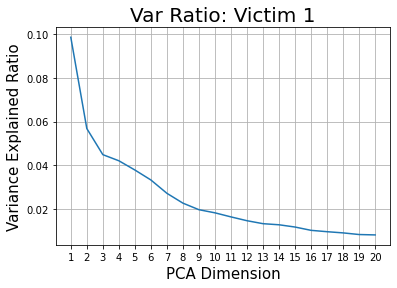

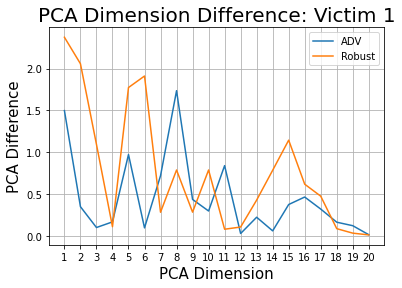

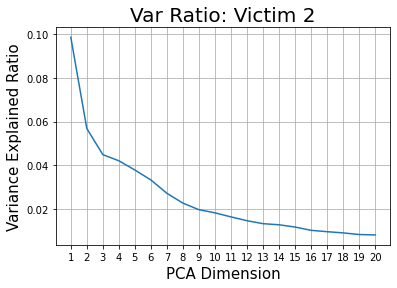

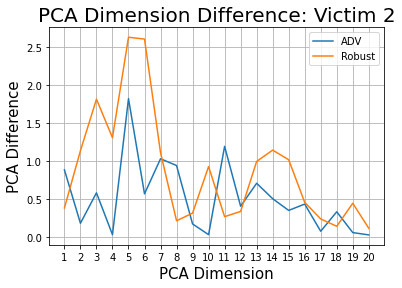

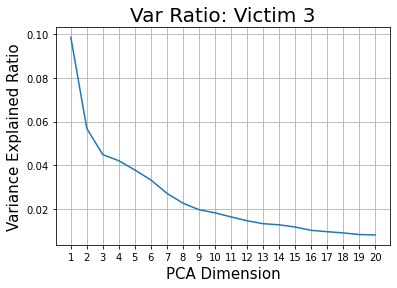

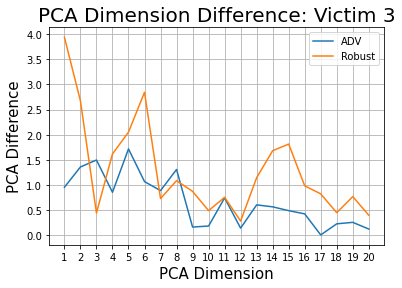

In [10]:
# Plot data storage
num_PCA_dim = 20
store_PCA_diff = np.zeros([len(victim_idxs),2,num_PCA_dim])

transferer.set_data(mode='client', datasets = victim_idxs, batch_size = batch_size)
transferer.set_data_advNN()
transferer.forward_pass()

# Loop through each user here
for i in range(len(victim_idxs)):
    j = victim_idxs[i]
    transferer.obtain_PCA(analyze_atk = True, advrobust_idx = j, dim=num_PCA_dim)
    data = transferer.PCA_data
    filtered_data = {}
    explained_var_ratio = transferer.explained_var_ratio
    
    targets = [[victim_idxs[i],0],[victim_idxs[i],1],[victim_idxs[i],2]]
    
    for target in targets:
        idx_temp0 = transferer.PCA_data['labels'][:,0] == target[0]
        idx_temp1 = transferer.PCA_data['labels'][:,1] == target[1]

        indicesToKeep = idx_temp0 * idx_temp1
        
        filtered_data[target[1]] = data['data'][indicesToKeep]
    
    adv_pca = np.abs(np.mean(filtered_data[1],axis=0) - np.mean(filtered_data[0],axis=0))
    robust_pca = np.abs(np.mean(filtered_data[2],axis=0) - np.mean(filtered_data[0],axis=0))
    
    # Generate two plots
    dim_axis = np.arange(num_PCA_dim) + 1
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('PCA Dimension', fontsize = 15)
    ax.set_ylabel('Variance Explained Ratio', fontsize = 15)
    ax.set_title('Var Ratio: Victim '+str(j), fontsize = 20)
    ax.plot(dim_axis,explained_var_ratio)
    ax.set_xticks(dim_axis)
    ax.grid()
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('PCA Dimension', fontsize = 15)
    ax.set_ylabel('PCA Difference', fontsize = 15)
    ax.set_title('PCA Dimension Difference: Victim '+str(j), fontsize = 20)
    ax.plot(dim_axis,adv_pca,label="ADV")
    ax.plot(dim_axis,robust_pca,label="Robust")
    ax.legend()
    ax.set_xticks(dim_axis)
    ax.grid()